In [ ]:
# Create the directory structure
import os

dirs = [
    'results/gpt-4o-mini/mal_500/child',
    'results/gpt-4o-mini/mal_500/alice',

]

for dir_path in dirs:
    os.makedirs(dir_path, exist_ok=True)


upload factuality and hallucination files

In [ ]:
import os
import shutil
from google.colab import files

# Define the target directory path
target_dir = '/content/results/gpt-4o-mini/mal_500/alice'


uploaded = files.upload()

# Step 3: Process the uploaded file
for filename, content in uploaded.items():
    # Define the target path for the file
    target_path = os.path.join(target_dir, filename)

    # If file was uploaded to current directory, move it to target
    if os.path.exists(filename):
        shutil.move(filename, target_path)
    else:
        # Write the content directly to target location
        with open(target_path, 'wb') as f:
            f.write(content)

    print(f"✓ File '{filename}' saved to: {target_path}")



Saving hallucinationaliceturkish (1).json to hallucinationaliceturkish (1).json
Saving factualityaliceturkish (1).json to factualityaliceturkish (1).json
✓ File 'hallucinationaliceturkish (1).json' saved to: /content/results/gpt-4o-mini/mal_500/alice/hallucinationaliceturkish (1).json
✓ File 'factualityaliceturkish (1).json' saved to: /content/results/gpt-4o-mini/mal_500/alice/factualityaliceturkish (1).json


json to csv

In [ ]:
import json
import pandas as pd
from pathlib import Path

def fix_and_convert_large_json(json_path):
    """
    Fix and convert large/malformed JSON files.
    """
    print(f"Attempting to fix and convert: {json_path}")

    # Read the raw file content
    with open(json_path, 'rb') as f:
        raw_content = f.read()

    # Decode with error handling
    content = raw_content.decode('utf-8', errors='ignore')

    print(f"File size: {len(content)} bytes")

    # Method 1: Try to parse as-is
    try:
        data = json.loads(content)
        print(f"Successfully parsed {len(data)} records directly")
        return pd.DataFrame(data)
    except json.JSONDecodeError as e:
        print(f"Direct parsing failed at position {e.pos}: {e.msg}")

    # Method 2: Find and extract individual JSON objects
    records = []

    # Find the array boundaries
    array_start = content.find('[')
    array_end = content.rfind(']')

    if array_start != -1 and array_end != -1:
        array_content = content[array_start+1:array_end]
    else:
        array_content = content

    # Split by top-level commas between objects
    current_object = ""
    brace_depth = 0
    in_string = False
    escape_next = False

    for i, char in enumerate(array_content):
        if escape_next:
            current_object += char
            escape_next = False
            continue

        if char == '\\' and not escape_next:
            escape_next = True
            current_object += char
            continue

        if char == '"' and not escape_next:
            in_string = not in_string

        if not in_string:
            if char == '{':
                brace_depth += 1
            elif char == '}':
                brace_depth -= 1

        current_object += char

        # When we complete an object (depth returns to 0 after hitting 1+)
        if brace_depth == 0 and current_object.strip() and char == '}':
            try:
                # Clean up the object string
                obj_str = current_object.strip()
                if obj_str.endswith(','):
                    obj_str = obj_str[:-1]

                # Try to parse this object
                obj = json.loads(obj_str)
                records.append(obj)

                if len(records) % 1000 == 0:
                    print(f"  Parsed {len(records)} records so far...")

                current_object = ""

            except json.JSONDecodeError:
                # Skip malformed objects
                current_object = ""
            except Exception as e:
                current_object = ""

    print(f"Successfully extracted {len(records)} records")

    if records:
        return pd.DataFrame(records)
    else:
        return None

def convert_all_json_files(base_path='/content/results/gpt-4o-mini/mal_500/'):
    """
    Convert all JSON files with proper error handling.
    """
    results = {}

    # Dictionary to store counts for easy reference
    file_counts = {
        'alice': {'hallucination': 0, 'factuality': 0},
        'child': {'hallucination': 0, 'factuality': 0}
    }

    for setting in ['alice', 'child']:
        results[setting] = {}

        for file_type in ['hallucination', 'factuality']:
            json_path = f"{base_path}{setting}/{file_type}.json"
            csv_path = f"{base_path}{setting}/{file_type}.csv"

            if not Path(json_path).exists():
                print(f"File not found: {json_path}")
                continue

            print(f"\n{'='*70}")
            print(f"Processing: {setting}/{file_type}.json")
            print('='*70)

            # Convert the file
            df = fix_and_convert_large_json(json_path)

            if df is not None:
                # Store the count
                entry_count = len(df)
                file_counts[setting][file_type] = entry_count

                # Handle list columns before saving
                for col in df.columns:
                    if df[col].dtype == 'object':
                        # Check if column contains lists or dicts
                        sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
                        if sample is not None and (isinstance(sample, (list, dict))):
                            df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (list, dict)) else x)

                # Save to CSV
                df.to_csv(csv_path, index=False)

                print(f"✓ Saved {entry_count} records to {csv_path}")

                # Store results
                results[setting][file_type] = {
                    'records': entry_count,
                    'path': csv_path
                }

                # Also save a basic version with only key columns
                basic_columns = [
                    'true_answer', 'answer_text', 'classification',
                    'first_token_probability', 'prob_diff_top2',
                    'semantic_entropy', 'regular_entropy'
                ]

                available_basic = [col for col in basic_columns if col in df.columns]
                df_basic = df[available_basic]
                basic_csv_path = csv_path.replace('.csv', '_basic.csv')
                df_basic.to_csv(basic_csv_path, index=False)
                print(f"✓ Also saved basic version with {len(available_basic)} columns to {basic_csv_path}")
            else:
                print(f"✗ Failed to convert {json_path}")

    # Print detailed summary with counts
    print("\n" + "="*70)
    print("CONVERSION SUMMARY - ENTRY COUNTS")
    print("="*70)

    # Display counts in a formatted table
    print(f"\n{'Setting':<10} {'File Type':<15} {'Entry Count':<15}")
    print("-" * 40)

    for setting in ['alice', 'child']:
        for file_type in ['hallucination', 'factuality']:
            count = file_counts[setting][file_type]
            if count > 0:
                print(f"{setting.upper():<10} {file_type:<15} {count:<15,}")

    # Print totals
    print("-" * 40)
    total_alice = sum(file_counts['alice'].values())
    total_child = sum(file_counts['child'].values())
    total_hallucination = file_counts['alice']['hallucination'] + file_counts['child']['hallucination']
    total_factuality = file_counts['alice']['factuality'] + file_counts['child']['factuality']

    print(f"\nTOTALS BY SETTING:")
    print(f"  ALICE total: {total_alice:,} entries")
    print(f"  CHILD total: {total_child:,} entries")

    print(f"\nTOTALS BY FILE TYPE:")
    print(f"  Hallucination total: {total_hallucination:,} entries")
    print(f"  Factuality total: {total_factuality:,} entries")

    print(f"\nGRAND TOTAL: {total_alice + total_child:,} entries")

    return results, file_counts

# Run the conversion
if __name__ == "__main__":
    results, counts = convert_all_json_files()


Processing: alice/hallucination.json
Attempting to fix and convert: /content/results/gpt-4o-mini/mal_500/alice/hallucination.json
File size: 932726 bytes
Successfully parsed 465 records directly
✓ Saved 465 records to /content/results/gpt-4o-mini/mal_500/alice/hallucination.csv
✓ Also saved basic version with 7 columns to /content/results/gpt-4o-mini/mal_500/alice/hallucination_basic.csv

Processing: alice/factuality.json
Attempting to fix and convert: /content/results/gpt-4o-mini/mal_500/alice/factuality.json
File size: 16321624 bytes
Successfully parsed 8303 records directly
✓ Saved 8303 records to /content/results/gpt-4o-mini/mal_500/alice/factuality.csv
✓ Also saved basic version with 7 columns to /content/results/gpt-4o-mini/mal_500/alice/factuality_basic.csv

Processing: child/hallucination.json
Attempting to fix and convert: /content/results/gpt-4o-mini/mal_500/child/hallucination.json
File size: 783180 bytes
Successfully parsed 464 records directly
✓ Saved 464 records to /cont

Optimal Threshold for each metric



ALICE

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/alice'
SAMPLE_SIZE = 178
N_RUNS = 10  # Number of times to repeat the sampling for stability

# --- Helper Functions ---

def load_data(base_path):
    fact_path = os.path.join(base_path, 'factuality_basic.csv')
    hall_path = os.path.join(base_path, 'hallucination_basic.csv')

    if not os.path.exists(fact_path) or not os.path.exists(hall_path):
        print(f"Error: Files not found at {base_path}")
        return None, None

    df_f = pd.read_csv(fact_path)
    df_h = pd.read_csv(hall_path)
    return df_f, df_h

def get_optimal_threshold_single_run(df_f_sample, df_h_sample, metric, mode):
    # Combine values to find candidate thresholds
    all_values = np.concatenate([df_f_sample[metric].values, df_h_sample[metric].values])
    thresholds = np.unique(all_values)
    thresholds = np.sort(thresholds)

    min_error = float('inf')
    best_t = thresholds[0]
    best_cm = {}

    for t in thresholds:
        if mode == 'high_certainty':
            # F > t (Certain), H <= t (Uncertain)
            fn = np.sum(df_f_sample[metric] <= t) # Fact marked uncertain
            fp = np.sum(df_h_sample[metric] > t)  # Hallucination marked certain

        else:
            # F < t (Certain), H >= t (Uncertain)
            fn = np.sum(df_f_sample[metric] >= t) # Fact marked uncertain
            fp = np.sum(df_h_sample[metric] < t)  # Hallucination marked certain


        total_error = fn + fp

        if total_error < min_error:
            min_error = total_error
            best_t = t
            best_cm = {'FP': fp, 'FN': fn}

    return best_t, min_error, best_cm


df_f_all, df_h_all = load_data(BASE_PATH)

if df_f_all is not None:
    print(f"Loaded Full Data: {len(df_f_all)} Facts, {len(df_h_all)} Hallucinations")
    print(f"Running stability check with {N_RUNS} iterations of {SAMPLE_SIZE} samples each...")
    print("=" * 70)

    metrics_config = [
        {'col': 'first_token_probability', 'mode': 'high_certainty'},
        {'col': 'prob_diff_top2',          'mode': 'high_certainty'},
        {'col': 'semantic_entropy',        'mode': 'low_certainty'}
    ]

    for config in metrics_config:
        metric = config['col']
        mode = config['mode']

        thresholds = []
        cms = { 'FP': [], 'FN': []}
        errors = []

        # Stability Loop
        for i in range(N_RUNS):
            # Sample fresh data each time
            # Using i as random_state ensures different sample per loop, but reproducible overall
            cur_f = df_f_all.sample(n=SAMPLE_SIZE, random_state=i)
            cur_h = df_h_all.sample(n=SAMPLE_SIZE, random_state=i)

            t, err, cm = get_optimal_threshold_single_run(cur_f, cur_h, metric, mode)

            thresholds.append(t)
            errors.append(err)
            for k in cms:
                cms[k].append(cm[k])

        # Averages
        avg_threshold = np.mean(thresholds)
        avg_error = np.mean(errors)
        avg_cm = {k: np.mean(v) for k, v in cms.items()}

        print(f"METRIC: {metric}")
        print(f"  Avg Optimal Threshold: {avg_threshold:.6f}")

        print("-" * 70)

Loaded Full Data: 8303 Facts, 465 Hallucinations
Running stability check with 10 iterations of 178 samples each...
METRIC: first_token_probability
  Avg Optimal Threshold: 0.496290
----------------------------------------------------------------------
METRIC: prob_diff_top2
  Avg Optimal Threshold: 0.042118
----------------------------------------------------------------------
METRIC: semantic_entropy
  Avg Optimal Threshold: 0.022965
----------------------------------------------------------------------


child

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/child'
SAMPLE_SIZE = 178
N_RUNS = 10  # Number of times to repeat the sampling for stability

# --- Helper Functions ---

def load_data(base_path):
    fact_path = os.path.join(base_path, 'factuality_basic.csv')
    hall_path = os.path.join(base_path, 'hallucination_basic.csv')

    if not os.path.exists(fact_path) or not os.path.exists(hall_path):
        print(f"Error: Files not found at {base_path}")
        return None, None

    df_f = pd.read_csv(fact_path)
    df_h = pd.read_csv(hall_path)
    return df_f, df_h

def get_optimal_threshold_single_run(df_f_sample, df_h_sample, metric, mode):
    # Combine values to find candidate thresholds
    all_values = np.concatenate([df_f_sample[metric].values, df_h_sample[metric].values])
    thresholds = np.unique(all_values)
    thresholds = np.sort(thresholds)

    min_error = float('inf')
    best_t = thresholds[0]
    best_cm = {}

    for t in thresholds:
        if mode == 'high_certainty':
            # F > t (Certain), H <= t (Uncertain)
            fn = np.sum(df_f_sample[metric] <= t) # Fact marked uncertain
            fp = np.sum(df_h_sample[metric] > t)  # Hallucination marked certain

        else:
            # F < t (Certain), H >= t (Uncertain)
            fn = np.sum(df_f_sample[metric] >= t) # Fact marked uncertain
            fp = np.sum(df_h_sample[metric] < t)  # Hallucination marked certain


        total_error = fn + fp

        if total_error < min_error:
            min_error = total_error
            best_t = t
            best_cm = {'FP': fp, 'FN': fn}

    return best_t, min_error, best_cm


df_f_all, df_h_all = load_data(BASE_PATH)

if df_f_all is not None:
    print(f"Loaded Full Data: {len(df_f_all)} Facts, {len(df_h_all)} Hallucinations")
    print(f"Running stability check with {N_RUNS} iterations of {SAMPLE_SIZE} samples each...")
    print("=" * 70)

    metrics_config = [
        {'col': 'first_token_probability', 'mode': 'high_certainty'},
        {'col': 'prob_diff_top2',          'mode': 'high_certainty'},
        {'col': 'semantic_entropy',        'mode': 'low_certainty'}
    ]

    for config in metrics_config:
        metric = config['col']
        mode = config['mode']

        thresholds = []
        cms = { 'FP': [], 'FN': []}
        errors = []

        # Stability Loop
        for i in range(N_RUNS):
            # Sample fresh data each time
            # Using i as random_state ensures different sample per loop, but reproducible overall
            cur_f = df_f_all.sample(n=SAMPLE_SIZE, random_state=i)
            cur_h = df_h_all.sample(n=SAMPLE_SIZE, random_state=i)

            t, err, cm = get_optimal_threshold_single_run(cur_f, cur_h, metric, mode)

            thresholds.append(t)
            errors.append(err)
            for k in cms:
                cms[k].append(cm[k])

        # Averages
        avg_threshold = np.mean(thresholds)
        avg_error = np.mean(errors)
        avg_cm = {k: np.mean(v) for k, v in cms.items()}

        print(f"METRIC: {metric}")
        print(f"  Avg Optimal Threshold: {avg_threshold:.6f}")

        print("-" * 70)

Loaded Full Data: 8304 Facts, 464 Hallucinations
Running stability check with 10 iterations of 178 samples each...
METRIC: first_token_probability
  Avg Optimal Threshold: 0.322565
----------------------------------------------------------------------
METRIC: prob_diff_top2
  Avg Optimal Threshold: 0.483494
----------------------------------------------------------------------
METRIC: semantic_entropy
  Avg Optimal Threshold: 0.016184
----------------------------------------------------------------------


Confusion matrix for each metric

alice

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/alice'

# The specific thresholds you provided
THRESHOLDS = {
    'first_token_probability': 0.496290,
    'prob_diff_top2':          0.042118,
    'semantic_entropy':        0.022965
}

# Metric directions (same as before)
METRIC_CONFIG = {
    'first_token_probability': 'higher_is_certain', # Fact > T
    'prob_diff_top2':          'higher_is_certain', # Fact > T
    'semantic_entropy':        'lower_is_certain'   # Fact < T
}

def calculate_full_confusion_matrix(df_f, df_h, metric, threshold, mode):
    # 1. Evaluate Facts (Set F)
    # We want Facts to be CERTAIN.
    if mode == 'higher_is_certain':
        # Predict Certain if value > threshold
        f_certain_mask = df_f[metric] > threshold
    else:
        # Predict Certain if value < threshold
        f_certain_mask = df_f[metric] < threshold

    # TP: Facts correctly marked Certain
    tp = np.sum(f_certain_mask)
    # FN: Facts incorrectly marked Uncertain (Rejected)
    fn = len(df_f) - tp

    # 2. Evaluate Hallucinations (Set H)
    # We want Hallucinations to be UNCERTAIN.
    if mode == 'higher_is_certain':
        # Predict Uncertain if value <= threshold
        h_uncertain_mask = df_h[metric] <= threshold
    else:
        # Predict Uncertain if value >= threshold
        h_uncertain_mask = df_h[metric] >= threshold

    # TN: Hallucinations correctly marked Uncertain (Caught)
    tn = np.sum(h_uncertain_mask)
    # FP: Hallucinations incorrectly marked Certain (Missed/Leakage)
    fp = len(df_h) - tn

    return {'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp}

# --- Main Execution ---

# Load full datasets
fact_path = os.path.join(BASE_PATH, 'factuality_basic.csv')
hall_path = os.path.join(BASE_PATH, 'hallucination_basic.csv')

if os.path.exists(fact_path) and os.path.exists(hall_path):
    df_f_all = pd.read_csv(fact_path)
    df_h_all = pd.read_csv(hall_path)

    print(f"Dataset Loaded: {len(df_f_all)} Facts, {len(df_h_all)} Hallucinations")
    print("=" * 60)

    for metric, threshold in THRESHOLDS.items():
        mode = METRIC_CONFIG[metric]
        cm = calculate_full_confusion_matrix(df_f_all, df_h_all, metric, threshold, mode)

        print(f"METRIC: {metric}")
        print(f"  Applied Threshold: {threshold}")
        print(f"  Confusion Matrix (Full Data):")
        print(f"    True Positives (Facts Kept):           {cm['TP']}  ({cm['TP']/len(df_f_all):.1%})")
        print(f"    False Negatives (Facts Rejected):      {cm['FN']}  ({cm['FN']/len(df_f_all):.1%})")
        print(f"    True Negatives (Hallucinations Caught):{cm['TN']}  ({cm['TN']/len(df_h_all):.1%})")
        print(f"    False Positives (Hallucinations Leak): {cm['FP']}  ({cm['FP']/len(df_h_all):.1%})")
        print("-" * 60)

else:
    print(f"Error: Files not found at {BASE_PATH}")

Dataset Loaded: 8303 Facts, 465 Hallucinations
METRIC: first_token_probability
  Applied Threshold: 0.49629
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           8301  (100.0%)
    False Negatives (Facts Rejected):      2  (0.0%)
    True Negatives (Hallucinations Caught):3  (0.6%)
    False Positives (Hallucinations Leak): 462  (99.4%)
------------------------------------------------------------
METRIC: prob_diff_top2
  Applied Threshold: 0.042118
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           8298  (99.9%)
    False Negatives (Facts Rejected):      5  (0.1%)
    True Negatives (Hallucinations Caught):16  (3.4%)
    False Positives (Hallucinations Leak): 449  (96.6%)
------------------------------------------------------------
METRIC: semantic_entropy
  Applied Threshold: 0.022965
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           7269  (87.5%)
    False Negatives (Facts Rejected):      1034  (12.5%)
    True Neg

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/child'

# The specific thresholds you provided
THRESHOLDS = {
    'first_token_probability': 0.322565,
    'prob_diff_top2':          0.483494,
    'semantic_entropy':        0.016184
}

# Metric directions (same as before)
METRIC_CONFIG = {
    'first_token_probability': 'higher_is_certain', # Fact > T
    'prob_diff_top2':          'higher_is_certain', # Fact > T
    'semantic_entropy':        'lower_is_certain'   # Fact < T
}

def calculate_full_confusion_matrix(df_f, df_h, metric, threshold, mode):
    # 1. Evaluate Facts (Set F)
    # We want Facts to be CERTAIN.
    if mode == 'higher_is_certain':
        # Predict Certain if value > threshold
        f_certain_mask = df_f[metric] > threshold
    else:
        # Predict Certain if value < threshold
        f_certain_mask = df_f[metric] < threshold

    # TP: Facts correctly marked Certain
    tp = np.sum(f_certain_mask)
    # FN: Facts incorrectly marked Uncertain (Rejected)
    fn = len(df_f) - tp

    # 2. Evaluate Hallucinations (Set H)
    # We want Hallucinations to be UNCERTAIN.
    if mode == 'higher_is_certain':
        # Predict Uncertain if value <= threshold
        h_uncertain_mask = df_h[metric] <= threshold
    else:
        # Predict Uncertain if value >= threshold
        h_uncertain_mask = df_h[metric] >= threshold

    # TN: Hallucinations correctly marked Uncertain (Caught)
    tn = np.sum(h_uncertain_mask)
    # FP: Hallucinations incorrectly marked Certain (Missed/Leakage)
    fp = len(df_h) - tn

    return {'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp}

# --- Main Execution ---

# Load full datasets
fact_path = os.path.join(BASE_PATH, 'factuality_basic.csv')
hall_path = os.path.join(BASE_PATH, 'hallucination_basic.csv')

if os.path.exists(fact_path) and os.path.exists(hall_path):
    df_f_all = pd.read_csv(fact_path)
    df_h_all = pd.read_csv(hall_path)

    print(f"Dataset Loaded: {len(df_f_all)} Facts, {len(df_h_all)} Hallucinations")
    print("=" * 60)

    for metric, threshold in THRESHOLDS.items():
        mode = METRIC_CONFIG[metric]
        cm = calculate_full_confusion_matrix(df_f_all, df_h_all, metric, threshold, mode)

        print(f"METRIC: {metric}")
        print(f"  Applied Threshold: {threshold}")
        print(f"  Confusion Matrix (Full Data):")
        print(f"    True Positives (Facts Kept):           {cm['TP']}  ({cm['TP']/len(df_f_all):.1%})")
        print(f"    False Negatives (Facts Rejected):      {cm['FN']}  ({cm['FN']/len(df_f_all):.1%})")
        print(f"    True Negatives (Hallucinations Caught):{cm['TN']}  ({cm['TN']/len(df_h_all):.1%})")
        print(f"    False Positives (Hallucinations Leak): {cm['FP']}  ({cm['FP']/len(df_h_all):.1%})")
        print("-" * 60)

else:
    print(f"Error: Files not found at {BASE_PATH}")

Dataset Loaded: 8304 Facts, 464 Hallucinations
METRIC: first_token_probability
  Applied Threshold: 0.322565
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           8303  (100.0%)
    False Negatives (Facts Rejected):      1  (0.0%)
    True Negatives (Hallucinations Caught):2  (0.4%)
    False Positives (Hallucinations Leak): 462  (99.6%)
------------------------------------------------------------
METRIC: prob_diff_top2
  Applied Threshold: 0.483494
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           8295  (99.9%)
    False Negatives (Facts Rejected):      9  (0.1%)
    True Negatives (Hallucinations Caught):12  (2.6%)
    False Positives (Hallucinations Leak): 452  (97.4%)
------------------------------------------------------------
METRIC: semantic_entropy
  Applied Threshold: 0.016184
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           7432  (89.5%)
    False Negatives (Facts Rejected):      872  (10.5%)
    True Neg

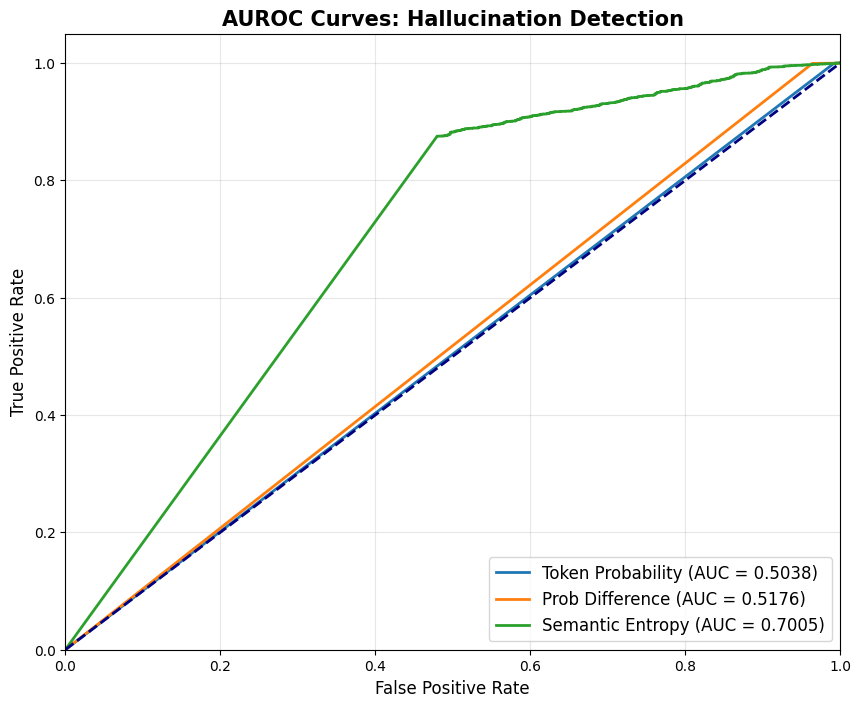


       PRECISION AND RECALL (Calculated from provided stats)
METRIC                    | PRECISION    | RECALL      
-------------------------------------------------------
first_token_probability   | 0.9473       | 0.9998
prob_diff_top2            | 0.9487       | 0.9994
semantic_entropy          | 0.9698       | 0.8755
-------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

# ==========================================
# PART 1: Generate AUROC Curves (Requires Data Files)
# ==========================================

# 1. Configuration
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/alice'
FACT_PATH = os.path.join(BASE_PATH, 'factuality_basic.csv')
HALL_PATH = os.path.join(BASE_PATH, 'hallucination_basic.csv')

# 2. Load Data for Curves
# We wrap this in a try/except block to ensure the code works even if files are missing
# (in that case, it will skip the graph and just print the stats).
if os.path.exists(FACT_PATH) and os.path.exists(HALL_PATH):
    try:
        df_f = pd.read_csv(FACT_PATH)
        df_h = pd.read_csv(HALL_PATH)

        # Prepare Labels (1 = Fact/Correct, 0 = Hallucination)
        y_true = np.concatenate([np.ones(len(df_f)), np.zeros(len(df_h))])

        # Metric Config
        metrics_config = [
            {'col': 'first_token_probability', 'label': 'Token Probability', 'invert': False},
            {'col': 'prob_diff_top2',          'label': 'Prob Difference',         'invert': False},
            {'col': 'semantic_entropy',        'label': 'Semantic Entropy',        'invert': True}
        ]

        # 3. Plot ROC Curves
        plt.figure(figsize=(10, 8))

        for config in metrics_config:
            col = config['col']

            # Get scores (Fill NaNs with 0 to prevent errors)
            scores_f = df_f[col].fillna(0).values
            scores_h = df_h[col].fillna(0).values
            y_scores = np.concatenate([scores_f, scores_h])

            # Invert entropy so "Higher" means "Better" (Correct) for the ROC function
            # (Because ROC assumes higher score = positive class)
            if config['invert']:
                y_scores = -y_scores

            # Calculate FPR and TPR
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, lw=2, label=f'{config["label"]} (AUC = {roc_auc:.4f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('AUROC Curves: Hallucination Detection', fontsize=15, fontweight='bold')
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting AUROC: {e}")

else:
    print(f"Note: Could not find CSV files at {BASE_PATH}. Skipping AUROC Graph generation.")

# ==========================================
# PART 2: Calculate Precision & Recall (From Your New Values)
# ==========================================

print("\n" + "="*60)
print("       PRECISION AND RECALL (Calculated from provided stats)")
print("="*60)

# New Data provided in your prompt
provided_stats = {
    'first_token_probability': {
        'TP': 8301, 'FN': 2, 'TN': 3, 'FP': 462
    },
    'prob_diff_top2': {
        'TP': 8298, 'FN': 5, 'TN': 16, 'FP': 449
    },
    'semantic_entropy': {
        'TP': 7269, 'FN': 1034, 'TN': 239, 'FP': 226
    }
}

print(f"{'METRIC':<25} | {'PRECISION':<12} | {'RECALL':<12}")
print("-" * 55)

for metric, counts in provided_stats.items():
    TP = counts['TP']
    FP = counts['FP']
    FN = counts['FN']

    # Formulas
    # Precision = TP / (TP + FP)  (Accuracy of positive predictions)
    # Recall    = TP / (TP + FN)  (Coverage of actual positives)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0

    print(f"{metric:<25} | {precision:.4f}       | {recall:.4f}")

print("-" * 55)

child

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/child'

# The specific thresholds you provided
THRESHOLDS = {
    'first_token_probability': 0.322565,
    'prob_diff_top2':          0.483494,
    'semantic_entropy':        0.016184
}

# Metric directions (same as before)
METRIC_CONFIG = {
    'first_token_probability': 'higher_is_certain', # Fact > T
    'prob_diff_top2':          'higher_is_certain', # Fact > T
    'semantic_entropy':        'lower_is_certain'   # Fact < T
}

def calculate_full_confusion_matrix(df_f, df_h, metric, threshold, mode):
    # 1. Evaluate Facts (Set F)
    # We want Facts to be CERTAIN.
    if mode == 'higher_is_certain':
        # Predict Certain if value > threshold
        f_certain_mask = df_f[metric] > threshold
    else:
        # Predict Certain if value < threshold
        f_certain_mask = df_f[metric] < threshold

    # TP: Facts correctly marked Certain
    tp = np.sum(f_certain_mask)
    # FN: Facts incorrectly marked Uncertain (Rejected)
    fn = len(df_f) - tp

    # 2. Evaluate Hallucinations (Set H)
    # We want Hallucinations to be UNCERTAIN.
    if mode == 'higher_is_certain':
        # Predict Uncertain if value <= threshold
        h_uncertain_mask = df_h[metric] <= threshold
    else:
        # Predict Uncertain if value >= threshold
        h_uncertain_mask = df_h[metric] >= threshold

    # TN: Hallucinations correctly marked Uncertain (Caught)
    tn = np.sum(h_uncertain_mask)
    # FP: Hallucinations incorrectly marked Certain (Missed/Leakage)
    fp = len(df_h) - tn

    return {'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp}

# --- Main Execution ---

# Load full datasets
fact_path = os.path.join(BASE_PATH, 'factuality_basic.csv')
hall_path = os.path.join(BASE_PATH, 'hallucination_basic.csv')

if os.path.exists(fact_path) and os.path.exists(hall_path):
    df_f_all = pd.read_csv(fact_path)
    df_h_all = pd.read_csv(hall_path)

    print(f"Dataset Loaded: {len(df_f_all)} Facts, {len(df_h_all)} Hallucinations")
    print("=" * 60)

    for metric, threshold in THRESHOLDS.items():
        mode = METRIC_CONFIG[metric]
        cm = calculate_full_confusion_matrix(df_f_all, df_h_all, metric, threshold, mode)

        print(f"METRIC: {metric}")
        print(f"  Applied Threshold: {threshold}")
        print(f"  Confusion Matrix (Full Data):")
        print(f"    True Positives (Facts Kept):           {cm['TP']}  ({cm['TP']/len(df_f_all):.1%})")
        print(f"    False Negatives (Facts Rejected):      {cm['FN']}  ({cm['FN']/len(df_f_all):.1%})")
        print(f"    True Negatives (Hallucinations Caught):{cm['TN']}  ({cm['TN']/len(df_h_all):.1%})")
        print(f"    False Positives (Hallucinations Leak): {cm['FP']}  ({cm['FP']/len(df_h_all):.1%})")
        print("-" * 60)

else:
    print(f"Error: Files not found at {BASE_PATH}")

Dataset Loaded: 8304 Facts, 464 Hallucinations
METRIC: first_token_probability
  Applied Threshold: 0.322565
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           8303  (100.0%)
    False Negatives (Facts Rejected):      1  (0.0%)
    True Negatives (Hallucinations Caught):2  (0.4%)
    False Positives (Hallucinations Leak): 462  (99.6%)
------------------------------------------------------------
METRIC: prob_diff_top2
  Applied Threshold: 0.483494
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           8295  (99.9%)
    False Negatives (Facts Rejected):      9  (0.1%)
    True Negatives (Hallucinations Caught):12  (2.6%)
    False Positives (Hallucinations Leak): 452  (97.4%)
------------------------------------------------------------
METRIC: semantic_entropy
  Applied Threshold: 0.016184
  Confusion Matrix (Full Data):
    True Positives (Facts Kept):           7432  (89.5%)
    False Negatives (Facts Rejected):      872  (10.5%)
    True Neg

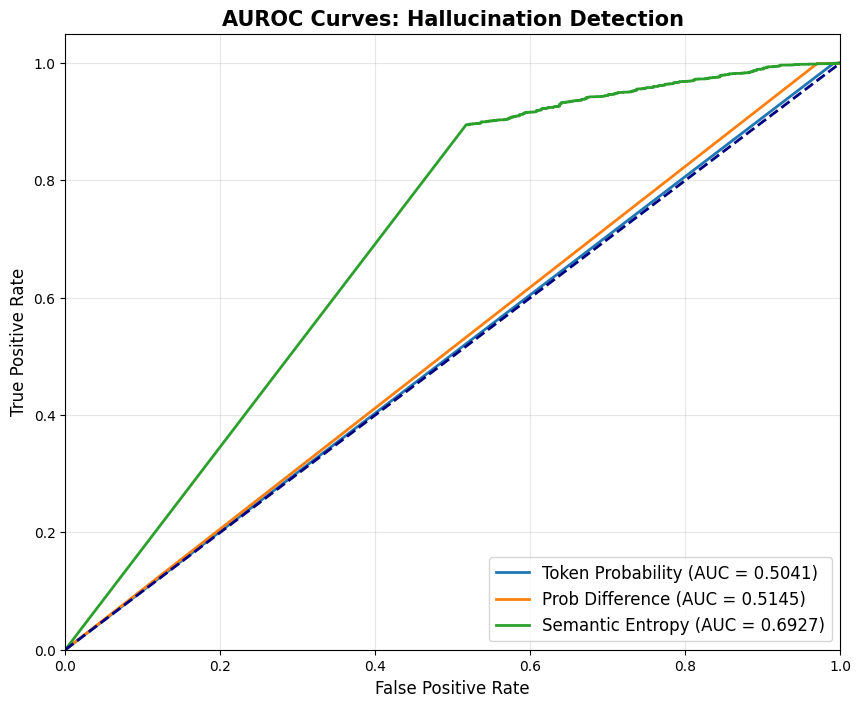


       PRECISION AND RECALL (Calculated from provided stats)
METRIC                    | PRECISION    | RECALL      
-------------------------------------------------------
first_token_probability   | 0.9473       | 0.9999
prob_diff_top2            | 0.9483       | 0.9989
semantic_entropy          | 0.9686       | 0.8950
-------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

# ==========================================
# PART 1: Generate AUROC Curves (Requires Data Files)
# ==========================================

# 1. Configuration
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/child'
FACT_PATH = os.path.join(BASE_PATH, 'factuality_basic.csv')
HALL_PATH = os.path.join(BASE_PATH, 'hallucination_basic.csv')

# 2. Load Data for Curves
if os.path.exists(FACT_PATH) and os.path.exists(HALL_PATH):
    try:
        df_f = pd.read_csv(FACT_PATH)
        df_h = pd.read_csv(HALL_PATH)

        # Prepare Labels (1 = Fact/Correct, 0 = Hallucination)
        y_true = np.concatenate([np.ones(len(df_f)), np.zeros(len(df_h))])

        # Metric Config
        metrics_config = [
            {'col': 'first_token_probability', 'label': 'Token Probability', 'invert': False},
            {'col': 'prob_diff_top2',          'label': 'Prob Difference',         'invert': False},
            {'col': 'semantic_entropy',        'label': 'Semantic Entropy',        'invert': True}
        ]

        # 3. Plot ROC Curves
        plt.figure(figsize=(10, 8))

        for config in metrics_config:
            col = config['col']

            # Get scores (Fill NaNs with 0 to prevent errors)
            scores_f = df_f[col].fillna(0).values
            scores_h = df_h[col].fillna(0).values
            y_scores = np.concatenate([scores_f, scores_h])

            # Invert entropy so "Higher" means "Better" (Correct) for the ROC function
            if config['invert']:
                y_scores = -y_scores

            # Calculate FPR and TPR
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, lw=2, label=f'{config["label"]} (AUC = {roc_auc:.4f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('AUROC Curves: Hallucination Detection', fontsize=15, fontweight='bold')
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting AUROC: {e}")

else:
    print(f"Note: Could not find CSV files at {BASE_PATH}. Skipping AUROC Graph generation.")

# ==========================================
# PART 2: Calculate Precision & Recall (From Your New Values)
# ==========================================

print("\n" + "="*60)
print("       PRECISION AND RECALL (Calculated from provided stats)")
print("="*60)

# New Data provided in your prompt
provided_stats = {
    'first_token_probability': {
        'TP': 8303, 'FN': 1, 'TN': 2, 'FP': 462
    },
    'prob_diff_top2': {
        'TP': 8295, 'FN': 9, 'TN': 12, 'FP': 452
    },
    'semantic_entropy': {
        'TP': 7432, 'FN': 872, 'TN': 223, 'FP': 241
    }
}

print(f"{'METRIC':<25} | {'PRECISION':<12} | {'RECALL':<12}")
print("-" * 55)

for metric, counts in provided_stats.items():
    TP = counts['TP']
    FP = counts['FP']
    FN = counts['FN']

    # Formulas
    # Precision = TP / (TP + FP)  (Accuracy of positive predictions)
    # Recall    = TP / (TP + FN)  (Coverage of actual positives)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0

    print(f"{metric:<25} | {precision:.4f}       | {recall:.4f}")

print("-" * 55)

Token probability cdf of both alice and child - hallucination

Prob difference cdf of both alice and child - hallucination

Semantic entropy cdf of alice and child - hallucination

CHOKE percentage in token probability alice and child- hallucinations

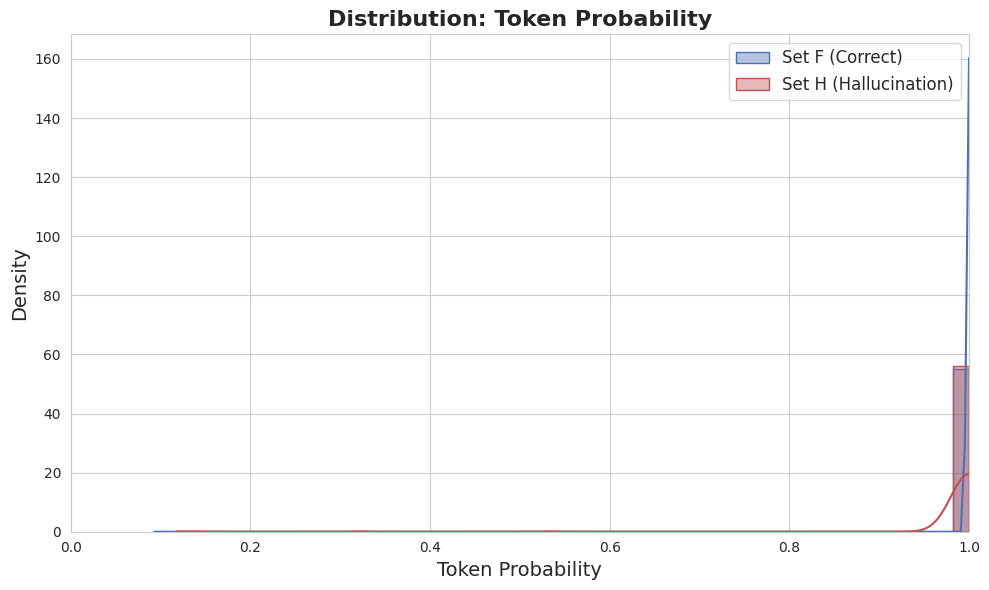

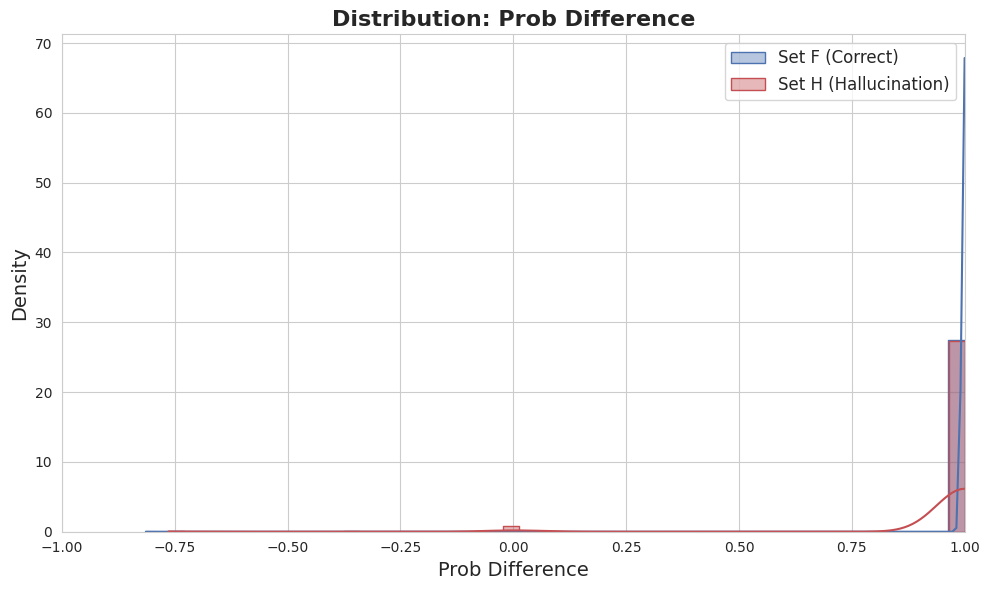

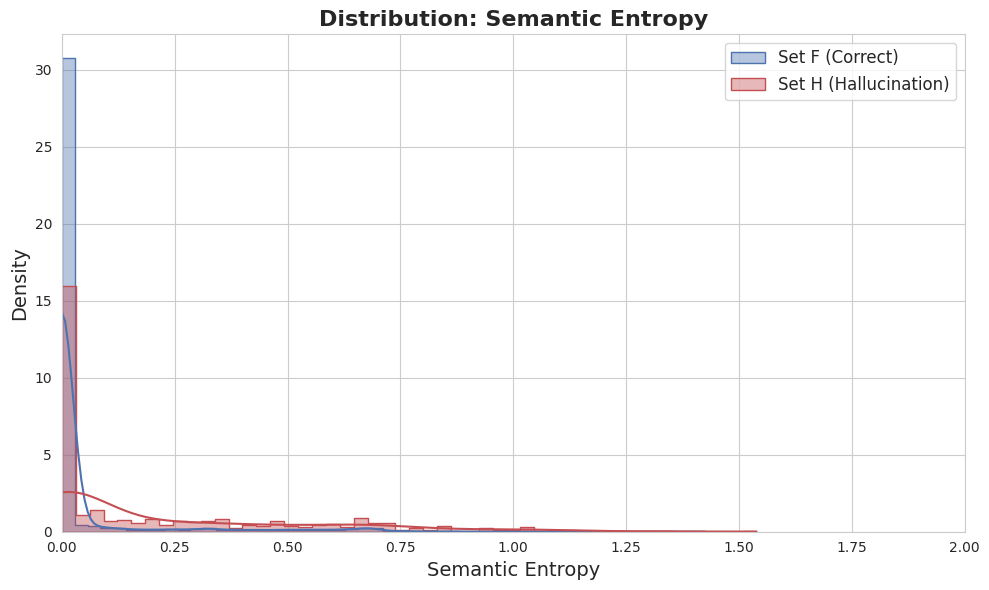

      STATISTICAL SUMMARY               

Metric: Token Probability
-----------------------------------------------------------------
Statistic       | Set F (Correct)      | Set H (Hallucination)
-----------------------------------------------------------------
count           | 8303.0000            | 465.0000            
mean            | 0.9996               | 0.9938              
std             | 0.0151               | 0.0688              
min             | 0.0930               | 0.1179              
25%             | 1.0000               | 1.0000              
50%             | 1.0000               | 1.0000              
75%             | 1.0000               | 1.0000              
max             | 1.0000               | 1.0000              

Metric: Prob Difference
-----------------------------------------------------------------
Statistic       | Set F (Correct)      | Set H (Hallucination)
-----------------------------------------------------------------
count           | 830

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Configuration and Data Loading
file_path_nh = '/content/results/gpt-4o-mini/mal_500/alice/factuality_basic.csv'     # Set F (Correct)
file_path_h = '/content/results/gpt-4o-mini/mal_500/alice/hallucination_basic.csv'   # Set H (Hallucinations)

# Safety check for file existence
if not os.path.exists(file_path_nh) or not os.path.exists(file_path_h):
    print("WARNING: Files not found. Please check the paths.")

# Load datasets
# (Assuming the files exist in your environment)
try:
    df_nh = pd.read_csv(file_path_nh)
    df_h = pd.read_csv(file_path_h)
except Exception as e:
    print(f"Error loading files: {e}")
    # Initialize empty DFs to prevent code crash if files are missing
    df_nh = pd.DataFrame()
    df_h = pd.DataFrame()

# 2. Metric Configuration
metrics_config = [
    {
        'col': 'first_token_probability',
        'label': 'Token Probability',
        'xlim': (0, 1)
    },
    {
        'col': 'prob_diff_top2',
        'label': 'Prob Difference',
        'xlim': (-1, 1)
    },
    {
        'col': 'semantic_entropy',
        'label': 'Semantic Entropy',
        'xlim': (0, 2)
    }
]

# 3. Plotting and Statistics
sns.set_style("whitegrid")
stats_output = []

if not df_nh.empty and not df_h.empty:
    for config in metrics_config:
        col = config['col']
        label = config['label']

        # Create a new independent figure for each metric
        plt.figure(figsize=(10, 6))

        # Extract data
        data_f = df_nh[col].dropna()
        data_h = df_h[col].dropna()

        # --- A. Calculate Statistics ---
        stats_f = data_f.describe()
        stats_h = data_h.describe()

        # Save statistics to print later
        stats_output.append(f"\nMetric: {label}")
        stats_output.append("-" * 65)
        stats_output.append(f"{'Statistic':<15} | {'Set F (Correct)':<20} | {'Set H (Hallucination)':<20}")
        stats_output.append("-" * 65)
        for stat_name in stats_f.index:
            val_f = stats_f[stat_name]
            val_h = stats_h[stat_name]
            stats_output.append(f"{stat_name:<15} | {val_f:<20.4f} | {val_h:<20.4f}")

        # --- B. Plot Histograms ---
        # Note: We do not pass 'ax=ax' here, so it plots on the current new figure
        sns.histplot(data_f, color='#4c72b0', label='Set F (Correct)',
                     stat="density", kde=True, element="step", alpha=0.4, bins=50)
        sns.histplot(data_h, color='#c44e52', label='Set H (Hallucination)',
                     stat="density", kde=True, element="step", alpha=0.4, bins=50)

        # --- Formatting ---
        plt.title(f'Distribution: {label}', fontsize=16, fontweight='bold')
        plt.xlabel(label, fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend(fontsize=12)

        # Apply the specific x-axis limits requested
        if 'xlim' in config:
            plt.xlim(config['xlim'])

        # Display this specific figure
        plt.tight_layout()
        plt.show()

    # 4. Print Statistics Summary at the end
    print("========================================")
    print("      STATISTICAL SUMMARY               ")
    print("========================================")
    for line in stats_output:
        print(line)
else:
    print("Skipping plots because dataframes are empty.")

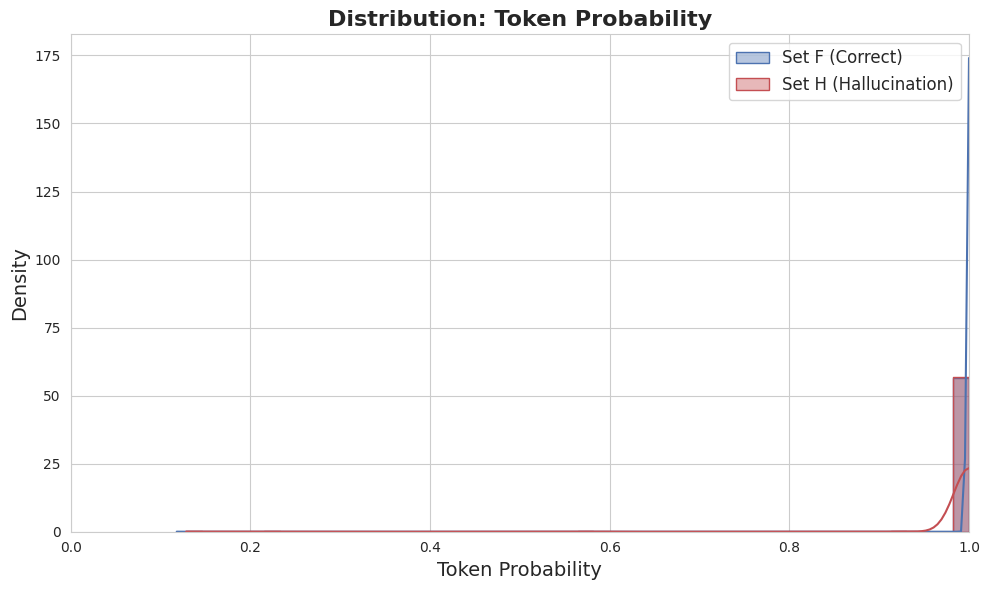

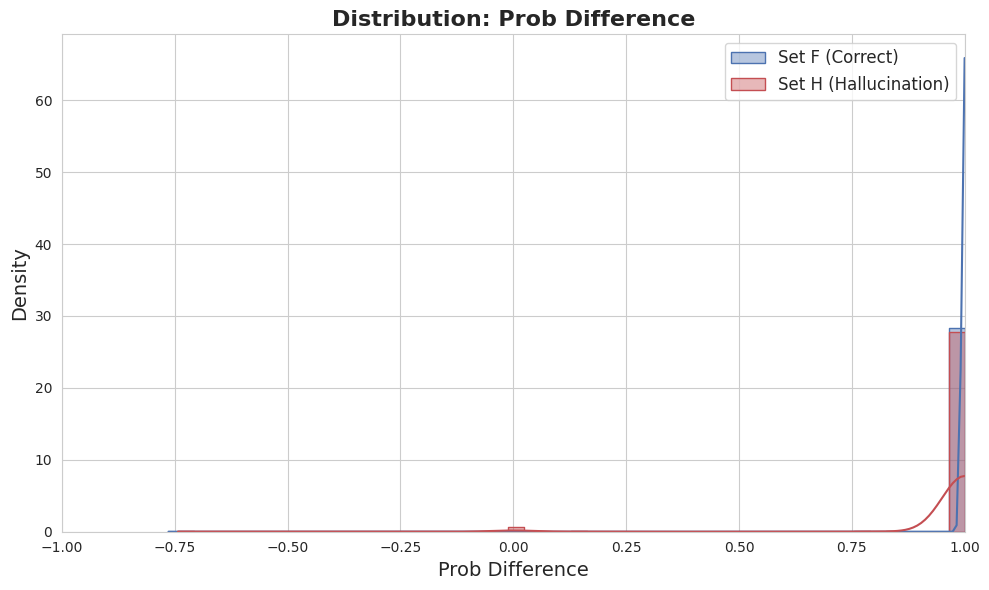

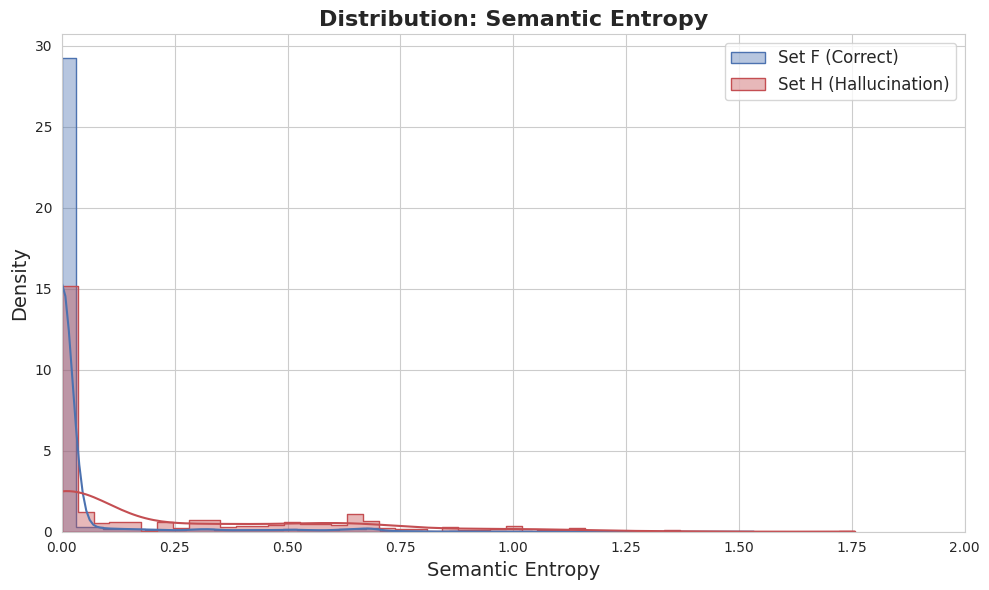

      STATISTICAL SUMMARY               

Metric: Token Probability
-----------------------------------------------------------------
Statistic       | Set F (Correct)      | Set H (Hallucination)
-----------------------------------------------------------------
count           | 8304.0000            | 464.0000            
mean            | 0.9997               | 0.9954              
std             | 0.0139               | 0.0578              
min             | 0.1181               | 0.1285              
25%             | 1.0000               | 1.0000              
50%             | 1.0000               | 1.0000              
75%             | 1.0000               | 1.0000              
max             | 1.0000               | 1.0000              

Metric: Prob Difference
-----------------------------------------------------------------
Statistic       | Set F (Correct)      | Set H (Hallucination)
-----------------------------------------------------------------
count           | 830

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Configuration and Data Loading
file_path_nh = '/content/results/gpt-4o-mini/mal_500/child/factuality_basic.csv'     # Set F (Correct)
file_path_h = '/content/results/gpt-4o-mini/mal_500/child/hallucination_basic.csv'   # Set H (Hallucinations)

# Safety check for file existence
if not os.path.exists(file_path_nh) or not os.path.exists(file_path_h):
    print("WARNING: Files not found. Please check the paths.")

# Load datasets
# (Assuming the files exist in your environment)
try:
    df_nh = pd.read_csv(file_path_nh)
    df_h = pd.read_csv(file_path_h)
except Exception as e:
    print(f"Error loading files: {e}")
    # Initialize empty DFs to prevent code crash if files are missing
    df_nh = pd.DataFrame()
    df_h = pd.DataFrame()

# 2. Metric Configuration
metrics_config = [
    {
        'col': 'first_token_probability',
        'label': 'Token Probability',
        'xlim': (0, 1)
    },
    {
        'col': 'prob_diff_top2',
        'label': 'Prob Difference',
        'xlim': (-1, 1)
    },
    {
        'col': 'semantic_entropy',
        'label': 'Semantic Entropy',
        'xlim': (0, 2)
    }
]

# 3. Plotting and Statistics
sns.set_style("whitegrid")
stats_output = []

if not df_nh.empty and not df_h.empty:
    for config in metrics_config:
        col = config['col']
        label = config['label']

        # Create a new independent figure for each metric
        plt.figure(figsize=(10, 6))

        # Extract data
        data_f = df_nh[col].dropna()
        data_h = df_h[col].dropna()

        # --- A. Calculate Statistics ---
        stats_f = data_f.describe()
        stats_h = data_h.describe()

        # Save statistics to print later
        stats_output.append(f"\nMetric: {label}")
        stats_output.append("-" * 65)
        stats_output.append(f"{'Statistic':<15} | {'Set F (Correct)':<20} | {'Set H (Hallucination)':<20}")
        stats_output.append("-" * 65)
        for stat_name in stats_f.index:
            val_f = stats_f[stat_name]
            val_h = stats_h[stat_name]
            stats_output.append(f"{stat_name:<15} | {val_f:<20.4f} | {val_h:<20.4f}")

        # --- B. Plot Histograms ---
        # Note: We do not pass 'ax=ax' here, so it plots on the current new figure
        sns.histplot(data_f, color='#4c72b0', label='Set F (Correct)',
                     stat="density", kde=True, element="step", alpha=0.4, bins=50)
        sns.histplot(data_h, color='#c44e52', label='Set H (Hallucination)',
                     stat="density", kde=True, element="step", alpha=0.4, bins=50)

        # --- Formatting ---
        plt.title(f'Distribution: {label}', fontsize=16, fontweight='bold')
        plt.xlabel(label, fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend(fontsize=12)

        # Apply the specific x-axis limits requested
        if 'xlim' in config:
            plt.xlim(config['xlim'])

        # Display this specific figure
        plt.tight_layout()
        plt.show()

    # 4. Print Statistics Summary at the end
    print("========================================")
    print("      STATISTICAL SUMMARY               ")
    print("========================================")
    for line in stats_output:
        print(line)
else:
    print("Skipping plots because dataframes are empty.")

alice

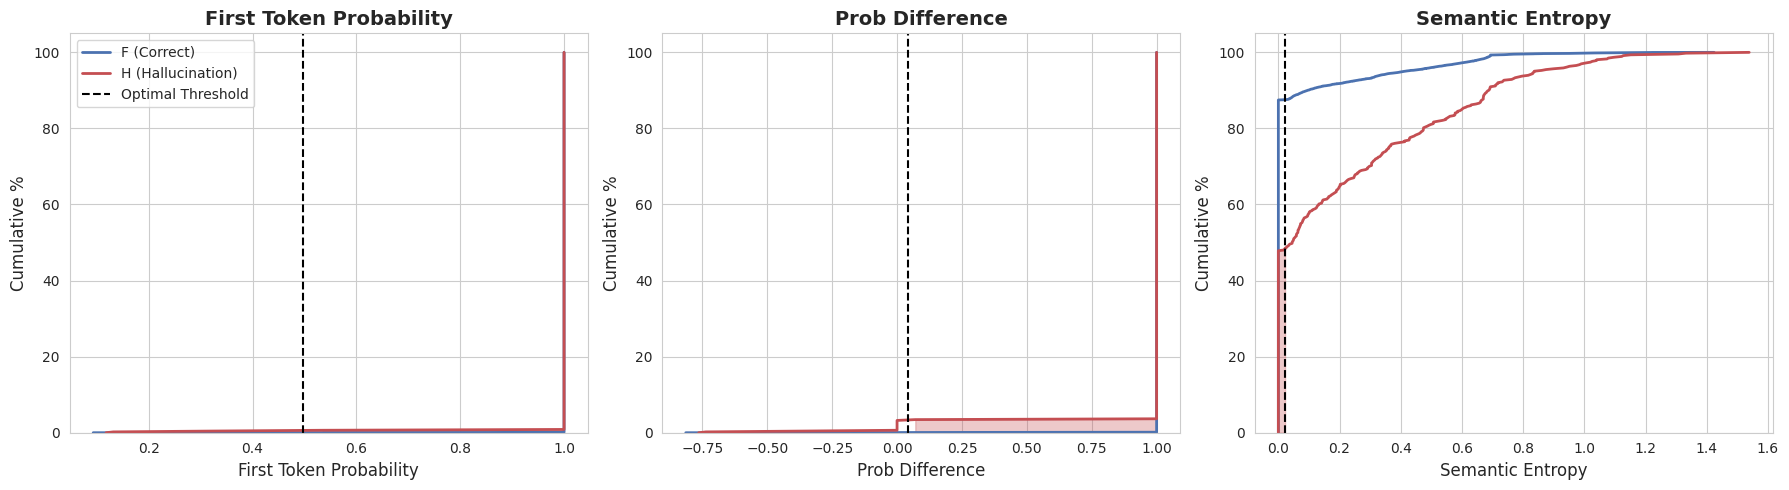

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Setup paths
base_path = '/content/results/gpt-4o-mini/mal_500/alice'
file_path_nh = os.path.join(base_path, 'factuality_basic.csv')     # Set F (Correct)
file_path_h = os.path.join(base_path, 'hallucination_basic.csv')   # Set H (Hallucinations)

# 2. Load the specific datasets
df_nh = pd.read_csv(file_path_nh)
df_h = pd.read_csv(file_path_h)

# 3. Define Metric Configurations based on your instructions
metrics_config = [
    {
        'col': 'first_token_probability',
        'label': 'First Token Probability',
        'threshold': 0.496290,
        'shade_direction': 'greater' # Certainty is high prob
    },
    {
        'col': 'prob_diff_top2',
        'label': 'Prob Difference',
        'threshold': 0.042118,
        'shade_direction': 'greater' # Certainty is high diff
    },
    {
        'col': 'semantic_entropy',
        'label': 'Semantic Entropy',
        'threshold': 0.023,
        'shade_direction': 'less'    # Certainty is low entropy
    }
]

def plot_cdf_subplots(df_correct, df_hallucination, metrics):
    # Create 3 subplots in a row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    sns.set_style("whitegrid")

    for ax, metric in zip(axes, metrics):
        col = metric['col']
        threshold = metric['threshold']

        # --- Prepare Data for CDF ---
        # Set F (NH/Correct) - Blue
        # Drop NAs to avoid errors
        data_nh = np.sort(df_correct[col].dropna())
        # Y-axis is 0 to 100%
        y_nh = 100. * np.arange(len(data_nh)) / (len(data_nh) - 1)

        # Set H (Hallucination) - Red
        data_h = np.sort(df_hallucination[col].dropna())
        y_h = 100. * np.arange(len(data_h)) / (len(data_h) - 1)

        # --- Plot Lines ---
        # Blue line for Correct answers
        ax.plot(data_nh, y_nh, label='F (Correct)', color='#4c72b0', linewidth=2)
        # Red line for Hallucinations
        ax.plot(data_h, y_h, label='H (Hallucination)', color='#c44e52', linewidth=2)

        # --- Plot Optimal Threshold (Black Dashed) ---
        ax.axvline(threshold, color='k', linestyle='--', linewidth=1.5, label='Optimal Threshold')

        # --- Handle Shading (Certain Hallucinations) ---
        # Shading red region where the model is "certain" but wrong
        if metric['shade_direction'] == 'less':
            # For Entropy: Model is certain when value is LOW (left of threshold)
            mask = data_h <= threshold
            # Fill between x-axis and the curve
            ax.fill_between(data_h[mask], 0, y_h[mask], color='#c44e52', alpha=0.3)

        elif metric['shade_direction'] == 'greater':
            # For Probability: Model is certain when value is HIGH (right of threshold)
            mask = data_h >= threshold
            ax.fill_between(data_h[mask], 0, y_h[mask], color='#c44e52', alpha=0.3)

        # --- Formatting ---
        ax.set_title(metric['label'], fontsize=14, fontweight='bold')
        ax.set_xlabel(metric['label'], fontsize=12) # x-axis label is the metric name
        ax.set_ylabel('Cumulative %', fontsize=12)
        ax.set_ylim(0, 105)

        # Add legend only to the first plot for cleanliness
        if metric['col'] == 'first_token_probability':
             ax.legend(loc='upper left', frameon=True)

    plt.tight_layout()
    plt.show()

# 4. Run the function
plot_cdf_subplots(df_nh, df_h, metrics_config)

CHILD

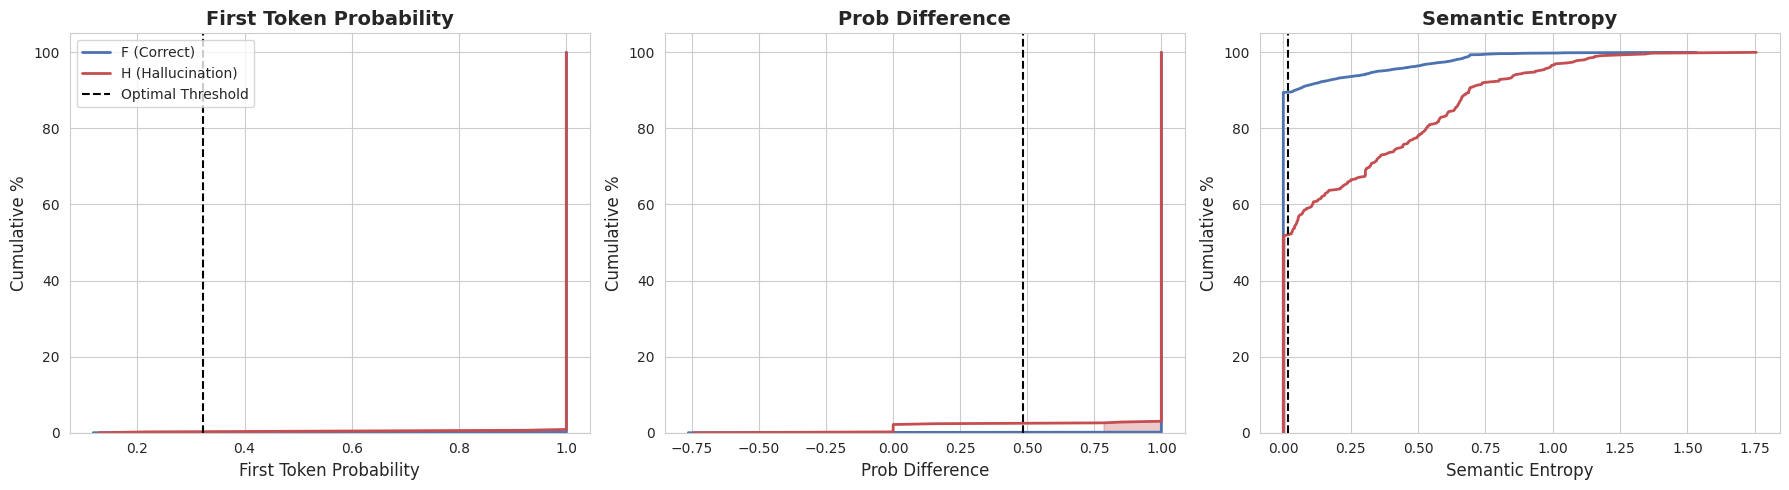

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Setup paths
base_path = '/content/results/gpt-4o-mini/mal_500/child'
file_path_nh = os.path.join(base_path, 'factuality_basic.csv')     # Set F (Correct)
file_path_h = os.path.join(base_path, 'hallucination_basic.csv')   # Set H (Hallucinations)

# 2. Load the specific datasets
df_nh = pd.read_csv(file_path_nh)
df_h = pd.read_csv(file_path_h)

# 3. Define Metric Configurations based on your instructions
metrics_config = [
    {
        'col': 'first_token_probability',
        'label': 'First Token Probability',
        'threshold': 0.322565,
        'shade_direction': 'greater' # Certainty is high prob
    },
    {
        'col': 'prob_diff_top2',
        'label': 'Prob Difference',
        'threshold': 0.483494,
        'shade_direction': 'greater' # Certainty is high diff
    },
    {
        'col': 'semantic_entropy',
        'label': 'Semantic Entropy',
        'threshold': 0.016184,
        'shade_direction': 'less'    # Certainty is low entropy
    }
]

def plot_cdf_subplots(df_correct, df_hallucination, metrics):
    # Create 3 subplots in a row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    sns.set_style("whitegrid")

    for ax, metric in zip(axes, metrics):
        col = metric['col']
        threshold = metric['threshold']

        # --- Prepare Data for CDF ---
        # Set F (NH/Correct) - Blue
        # Drop NAs to avoid errors
        data_nh = np.sort(df_correct[col].dropna())
        # Y-axis is 0 to 100%
        y_nh = 100. * np.arange(len(data_nh)) / (len(data_nh) - 1)

        # Set H (Hallucination) - Red
        data_h = np.sort(df_hallucination[col].dropna())
        y_h = 100. * np.arange(len(data_h)) / (len(data_h) - 1)

        # --- Plot Lines ---
        # Blue line for Correct answers
        ax.plot(data_nh, y_nh, label='F (Correct)', color='#4c72b0', linewidth=2)
        # Red line for Hallucinations
        ax.plot(data_h, y_h, label='H (Hallucination)', color='#c44e52', linewidth=2)

        # --- Plot Optimal Threshold (Black Dashed) ---
        ax.axvline(threshold, color='k', linestyle='--', linewidth=1.5, label='Optimal Threshold')

        # --- Handle Shading (Certain Hallucinations) ---
        # Shading red region where the model is "certain" but wrong
        if metric['shade_direction'] == 'less':
            # For Entropy: Model is certain when value is LOW (left of threshold)
            mask = data_h <= threshold
            # Fill between x-axis and the curve
            ax.fill_between(data_h[mask], 0, y_h[mask], color='#c44e52', alpha=0.3)

        elif metric['shade_direction'] == 'greater':
            # For Probability: Model is certain when value is HIGH (right of threshold)
            mask = data_h >= threshold
            ax.fill_between(data_h[mask], 0, y_h[mask], color='#c44e52', alpha=0.3)

        # --- Formatting ---
        ax.set_title(metric['label'], fontsize=14, fontweight='bold')
        ax.set_xlabel(metric['label'], fontsize=12) # x-axis label is the metric name
        ax.set_ylabel('Cumulative %', fontsize=12)
        ax.set_ylim(0, 105)

        # Add legend only to the first plot for cleanliness
        if metric['col'] == 'first_token_probability':
             ax.legend(loc='upper left', frameon=True)

    plt.tight_layout()
    plt.show()

# 4. Run the function
plot_cdf_subplots(df_nh, df_h, metrics_config)

CHOKE percentage in probability difference alice and child- hallucinations

CHOKE percentage in semantic entropy alice and child- hallucinations

Precison, Recall and AUROC

Jaccard similarity between hallucinationsin Alice and Child setting

      JACCARD SIMILARITY ANALYSIS (Alice vs Child)
Total Unique Hallucinations (Union): 568
Shared Hallucinations (Intersection): 315
------------------------------------------------------------
Alice Unique Hallucinations:          121
Child Unique Hallucinations:          132
------------------------------------------------------------
JACCARD SIMILARITY INDEX:             0.5546


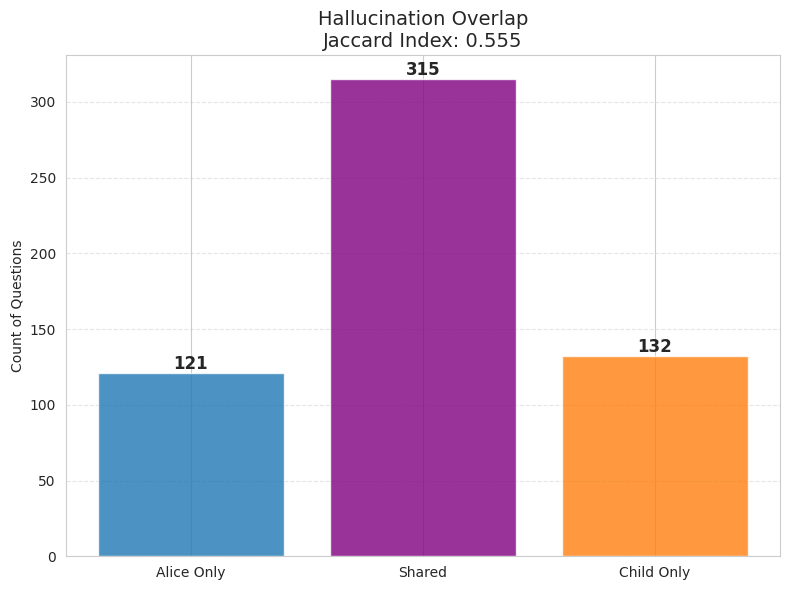

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Configuration ---
# Update these paths to point to your specific 'Alice' and 'Child' hallucination files
path_alice = '/content/results/gpt-4o-mini/mal_500/alice/hallucination_basic.csv'
path_child = '/content/results/gpt-4o-mini/mal_500/child/hallucination_basic.csv'

def compare_hallucinations(path_a, path_b):
    # 1. Load Data
    if not os.path.exists(path_a) or not os.path.exists(path_b):
        print("Error: One or both files not found.")
        return

    df_alice = pd.read_csv(path_a)
    df_child = pd.read_csv(path_b)

    # 2. Extract Sets of Questions
    # We use 'true_answer' as the unique ID for the question
    set_alice = set(df_alice['true_answer'].dropna().unique())
    set_child = set(df_child['true_answer'].dropna().unique())

    # 3. Calculate Jaccard Stats
    intersection = set_alice.intersection(set_child) # Questions BOTH hallucinated on
    union = set_alice.union(set_child)               # All unique questions hallucinated by EITHER

    alice_only = set_alice - set_child
    child_only = set_child - set_alice

    # Jaccard Index = (Intersection) / (Union)
    jaccard_index = len(intersection) / len(union) if len(union) > 0 else 0

    # 4. Print Statistics
    print("=" * 60)
    print("      JACCARD SIMILARITY ANALYSIS (Alice vs Child)")
    print("=" * 60)
    print(f"Total Unique Hallucinations (Union): {len(union)}")
    print(f"Shared Hallucinations (Intersection): {len(intersection)}")
    print("-" * 60)
    print(f"Alice Unique Hallucinations:          {len(alice_only)}")
    print(f"Child Unique Hallucinations:          {len(child_only)}")
    print("-" * 60)
    print(f"JACCARD SIMILARITY INDEX:             {jaccard_index:.4f}")
    print("=" * 60)

    # 5. Visualization
    plt.figure(figsize=(8, 6))
    categories = ['Alice Only', 'Shared', 'Child Only']
    counts = [len(alice_only), len(intersection), len(child_only)]
    colors = ['#1f77b4', '#800080', '#ff7f0e'] # Blue, Purple, Orange

    bars = plt.bar(categories, counts, color=colors, alpha=0.8)

    # Add counts on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title(f'Hallucination Overlap\nJaccard Index: {jaccard_index:.3f}', fontsize=14)
    plt.ylabel('Count of Questions')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Run the function
compare_hallucinations(path_alice, path_child)

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/alice'
SAMPLE_SIZE = 178
N_RUNS = 10  # Number of times to repeat the sampling for stability

# --- Helper Functions ---

def load_data(base_path):
    fact_path = os.path.join(base_path, 'factuality_basic.csv')
    hall_path = os.path.join(base_path, 'hallucination_basic.csv')

    if not os.path.exists(fact_path) or not os.path.exists(hall_path):
        print(f"Error: Files not found at {base_path}")
        return None, None

    df_f = pd.read_csv(fact_path)
    df_h = pd.read_csv(hall_path)
    return df_f, df_h

def get_optimal_threshold_single_run(df_f_sample, df_h_sample, metric, mode):
    # Combine values to find candidate thresholds
    all_values = np.concatenate([df_f_sample[metric].dropna().values, df_h_sample[metric].dropna().values])
    thresholds = np.unique(all_values)
    thresholds = np.sort(thresholds)

    # Downsample thresholds if necessary for speed
    if len(thresholds) > 2000:
        thresholds = np.linspace(thresholds.min(), thresholds.max(), 2000)

    min_error = float('inf')
    best_t = thresholds[0]

    # We want to minimize Total Error (False Negatives + False Positives)
    # FN = Fact marked Uncertain (Rejected)
    # FP = Hallucination marked Certain (Leakage/Unmitigated)

    for t in thresholds:
        if mode == 'high_certainty':
            # Metric > t is Certain
            # FN: Fact <= t
            # FP: Hallucination > t
            fn = np.sum(df_f_sample[metric] <= t)
            fp = np.sum(df_h_sample[metric] > t)
        else:
            # Metric < t is Certain (Low Entropy = Certain)
            # FN: Fact >= t
            # FP: Hallucination < t
            fn = np.sum(df_f_sample[metric] >= t)
            fp = np.sum(df_h_sample[metric] < t)

        total_error = fn + fp

        if total_error < min_error:
            min_error = total_error
            best_t = t

    return best_t, min_error

# --- Main Execution ---

df_f_all, df_h_all = load_data(BASE_PATH)

if df_f_all is not None:
    print(f"Loaded Full Data: {len(df_f_all)} Facts, {len(df_h_all)} Hallucinations")
    print(f"Running stability check with {N_RUNS} iterations of {SAMPLE_SIZE} samples each...")
    print("=" * 70)

    # Config specifically for Regular Entropy
    # Mode is 'low_certainty' because Lower Entropy = Higher Certainty
    metrics_config = [
        {'col': 'regular_entropy', 'mode': 'low_certainty'}
    ]

    for config in metrics_config:
        metric = config['col']
        mode = config['mode']

        thresholds = []
        errors = []

        # 1. Stability Loop (Finding the Avg Threshold)
        for i in range(N_RUNS):
            cur_f = df_f_all.sample(n=SAMPLE_SIZE, random_state=i)
            cur_h = df_h_all.sample(n=SAMPLE_SIZE, random_state=i)

            t, err = get_optimal_threshold_single_run(cur_f, cur_h, metric, mode)
            thresholds.append(t)
            errors.append(err)

        avg_threshold = np.mean(thresholds)

        print(f"METRIC: {metric}")
        print(f"  Avg Optimal Threshold (over {N_RUNS} runs): {avg_threshold:.6f}")

        # 2. Check Unmitigated Hallucinations on FULL H Set
        # Unmitigated = Hallucinations that pass as 'Certain' using the new threshold

        full_h_values = df_h_all[metric].dropna().values
        total_h = len(full_h_values)

        if mode == 'high_certainty':
            # Certain if > Threshold
            unmitigated_count = np.sum(full_h_values > avg_threshold)
        else:
            # Certain if < Threshold (Entropy case)
            unmitigated_count = np.sum(full_h_values < avg_threshold)

        pct_unmitigated = (unmitigated_count / total_h) * 100

        print("-" * 70)
        print(f"  UNMITIGATED HALLUCINATIONS (H Set Analysis)")
        print(f"  Total Hallucinations Checked:  {total_h}")
        print(f"  Unmitigated (Leaked):          {unmitigated_count} ({pct_unmitigated:.2f}%)")
        print(f"  Caught (Correctly Flagged):    {total_h - unmitigated_count} ({100 - pct_unmitigated:.2f}%)")
        print("=" * 70)

Loaded Full Data: 8303 Facts, 465 Hallucinations
Running stability check with 10 iterations of 178 samples each...
METRIC: regular_entropy
  Avg Optimal Threshold (over 10 runs): 1.804547
----------------------------------------------------------------------
  UNMITIGATED HALLUCINATIONS (H Set Analysis)
  Total Hallucinations Checked:  465
  Unmitigated (Leaked):          1 (0.22%)
  Caught (Correctly Flagged):    464 (99.78%)


In [ ]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
BASE_PATH = '/content/results/gpt-4o-mini/mal_500/child'
SAMPLE_SIZE = 178
N_RUNS = 10  # Number of times to repeat the sampling for stability

# --- Helper Functions ---

def load_data(base_path):
    fact_path = os.path.join(base_path, 'factuality_basic.csv')
    hall_path = os.path.join(base_path, 'hallucination_basic.csv')

    if not os.path.exists(fact_path) or not os.path.exists(hall_path):
        print(f"Error: Files not found at {base_path}")
        return None, None

    df_f = pd.read_csv(fact_path)
    df_h = pd.read_csv(hall_path)
    return df_f, df_h

def get_optimal_threshold_single_run(df_f_sample, df_h_sample, metric, mode):
    # Combine values to find candidate thresholds
    all_values = np.concatenate([df_f_sample[metric].dropna().values, df_h_sample[metric].dropna().values])
    thresholds = np.unique(all_values)
    thresholds = np.sort(thresholds)

    # Downsample thresholds if necessary for speed
    if len(thresholds) > 2000:
        thresholds = np.linspace(thresholds.min(), thresholds.max(), 2000)

    min_error = float('inf')
    best_t = thresholds[0]

    # We want to minimize Total Error (False Negatives + False Positives)
    # FN = Fact marked Uncertain (Rejected)
    # FP = Hallucination marked Certain (Leakage/Unmitigated)

    for t in thresholds:
        if mode == 'high_certainty':
            # Metric > t is Certain
            # FN: Fact <= t
            # FP: Hallucination > t
            fn = np.sum(df_f_sample[metric] <= t)
            fp = np.sum(df_h_sample[metric] > t)
        else:
            # Metric < t is Certain (Low Entropy = Certain)
            # FN: Fact >= t
            # FP: Hallucination < t
            fn = np.sum(df_f_sample[metric] >= t)
            fp = np.sum(df_h_sample[metric] < t)

        total_error = fn + fp

        if total_error < min_error:
            min_error = total_error
            best_t = t

    return best_t, min_error

# --- Main Execution ---

df_f_all, df_h_all = load_data(BASE_PATH)

if df_f_all is not None:
    print(f"Loaded Full Data: {len(df_f_all)} Facts, {len(df_h_all)} Hallucinations")
    print(f"Running stability check with {N_RUNS} iterations of {SAMPLE_SIZE} samples each...")
    print("=" * 70)

    # Config specifically for Regular Entropy
    # Mode is 'low_certainty' because Lower Entropy = Higher Certainty
    metrics_config = [
        {'col': 'regular_entropy', 'mode': 'low_certainty'}
    ]

    for config in metrics_config:
        metric = config['col']
        mode = config['mode']

        thresholds = []
        errors = []

        # 1. Stability Loop (Finding the Avg Threshold)
        for i in range(N_RUNS):
            cur_f = df_f_all.sample(n=SAMPLE_SIZE, random_state=i)
            cur_h = df_h_all.sample(n=SAMPLE_SIZE, random_state=i)

            t, err = get_optimal_threshold_single_run(cur_f, cur_h, metric, mode)
            thresholds.append(t)
            errors.append(err)

        avg_threshold = np.mean(thresholds)

        print(f"METRIC: {metric}")
        print(f"  Avg Optimal Threshold (over {N_RUNS} runs): {avg_threshold:.6f}")

        # 2. Check Unmitigated Hallucinations on FULL H Set
        # Unmitigated = Hallucinations that pass as 'Certain' using the new threshold

        full_h_values = df_h_all[metric].dropna().values
        total_h = len(full_h_values)

        if mode == 'high_certainty':
            # Certain if > Threshold
            unmitigated_count = np.sum(full_h_values > avg_threshold)
        else:
            # Certain if < Threshold (Entropy case)
            unmitigated_count = np.sum(full_h_values < avg_threshold)

        pct_unmitigated = (unmitigated_count / total_h) * 100

        print("-" * 70)
        print(f"  UNMITIGATED HALLUCINATIONS (H Set Analysis)")
        print(f"  Total Hallucinations Checked:  {total_h}")
        print(f"  Unmitigated (Leaked):          {unmitigated_count} ({pct_unmitigated:.2f}%)")
        print(f"  Caught (Correctly Flagged):    {total_h - unmitigated_count} ({100 - pct_unmitigated:.2f}%)")
        print("=" * 70)

Loaded Full Data: 8304 Facts, 464 Hallucinations
Running stability check with 10 iterations of 178 samples each...
METRIC: regular_entropy
  Avg Optimal Threshold (over 10 runs): 1.725128
----------------------------------------------------------------------
  UNMITIGATED HALLUCINATIONS (H Set Analysis)
  Total Hallucinations Checked:  464
  Unmitigated (Leaked):          1 (0.22%)
  Caught (Correctly Flagged):    463 (99.78%)


/tmp/ipython-input-1346888044.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


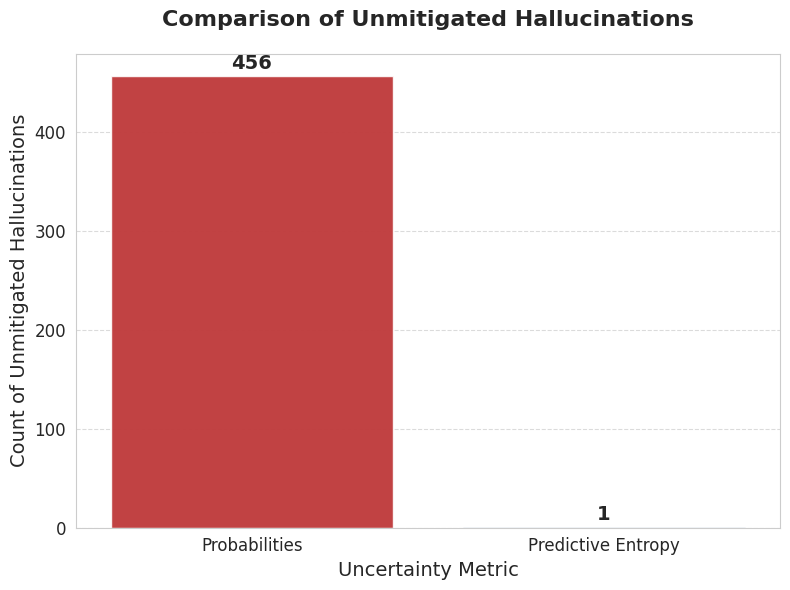

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# 1. Data Preparation
# ==========================================
# REPLACE THESE VALUES with the 'False Positives (FP)' count
# you got from your confusion matrix calculations for each metric.
# These are placeholder numbers based on your recent prompt history.

data = {
    'Metric': ['Probabilities', 'Predictive Entropy'],
    # Example FP values. Replace with your actual findings.
    'Unmitigated Count (FP)': [456, 1]
}

# Create a DataFrame for plotting
df_plot = pd.DataFrame(data)

# ==========================================
# 2. Create the Bar Plot
# ==========================================
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Create barplot
# Using a reddish color to signify "unmitigated" or "error"
ax = sns.barplot(x='Metric', y='Unmitigated Count (FP)', data=df_plot, color='#d62728', alpha=0.8)

# ==========================================
# 3. Formatting and Labels
# ==========================================
# Add exact counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, # Offset slightly above the bar
            f'{int(height)}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Titles and Axis Labels
plt.title('Comparison of Unmitigated Hallucinations', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Count of Unmitigated Hallucinations', fontsize=14)
plt.xlabel('Uncertainty Metric', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a subtle grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)
palette = ['#d62728', '#1f77b4']  # red, blue (change as needed)

ax = sns.barplot(
    x='Metric',
    y='Unmitigated Count (FP)',
    data=df_plot,
    palette=palette,
    alpha=0.85
)

# Final layout adjustment
plt.tight_layout()

# Show plot
plt.show()